### Getting started

In [5]:
import warnings

warnings.filterwarnings("ignore", message="Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.")

import numpy as np
import pandas as pd
import copy
import tqdm
import matplotlib.pyplot as plt

from collections import defaultdict
from jie import plot
from jie import aligner

###
# Multiprocessing
import multiprocessing.pool as mpp
from multiprocessing.pool import ThreadPool as Pool

# from https://stackoverflow.com/questions/57354700/starmap-combined-with-tqdm
# Author: Darkonaut (08/05/2019)

def istarmap(self, func, iterable, chunksize=1):
    """starmap-version of imap
    """
    self._check_running()
    if chunksize < 1:
        raise ValueError(
            "Chunksize must be 1+, not {0:n}".format(
                chunksize))

    task_batches = mpp.Pool._get_tasks(func, iterable, chunksize)
    result = mpp.IMapIterator(self)
    self._taskqueue.put(
        (
            self._guarded_task_generation(result._job,
                                          mpp.starmapstar,
                                          task_batches),
            result._set_length
        ))
    return (item for chunk in result for item in chunk)

mpp.Pool.istarmap = istarmap

### Setting up
- The rationale and documentation for the next few steps are discussed in `jie/jupyter/01-seqFISH-plus-mouse-ESC-spatial-genome-alignment`. 
1. __Download data__
2. __Reference Genome__
3. __Candidate spatial coordinates__

- After step 3, we can reorganize the spatial coordinates by cell.
- Distance parameters used for the manuscript is provided under `jie/data/params`


#### 1. Download data

In [6]:
%%bash
DIR="../data/mesc"
FILENAME="DNAseqFISH+.zip"
DESTINATION="../data/mesc/"
if [[ ! -e $DIR ]]; then
    mkdir ../data/mesc
    wget -i ../data/mesc_seqfish_urls.txt -P ../data/mesc
    unzip -j ${DIR}/${FILENAME} -d ${DIR} 
    rm ${DIR}/${FILENAME}
fi

#### 2. Reference genome

In [7]:
df = pd.read_csv("../data/TableS0_Mbcoords.csv")

# find genomic distance between each bin 
df_list = []

# for every chromosome
for chrom, group in df.groupby('Chrom'):
    
    # find genomic distance relative to preceding bin
    _df = copy.deepcopy(group)
    
    # sort by start
    _df.sort_values(by='Start', inplace = True)
    
    # record relative region ID (relative to chrom start site)
    _df['hyb'] = [i for i in range(_df.shape[0])]
    
    # calculate genomic distance relative to first starting position
    _df['delta'] = _df['Start'] - _df['Start'].iloc[0]
            
    df_list.append(_df)

# merge all dataframes
df_refgen = pd.concat(df_list)

#### 3. Candidate spatial coordinates

In [8]:
### HELPER FXN ###
def map_to_hyb(gene_name):
    return geneID_to_hyb[gene_name]

def map_to_chrom(gene_name):
    return geneID_to_chrom[gene_name]

# create lookup table for hyb
geneID_to_hyb = {name:hyb for name, hyb in zip(df_refgen['Name'], df_refgen['hyb'])}

# create lookup table for chrom
geneID_to_chrom = {name:chrom for name, chrom in zip(df_refgen['Name'], df_refgen['Chrom'])}

# read in dataframe
df_list = []
for file_ext in ['clonal24hr', 'clonal48hr', 'replicate1', 'replicate2']:
    
    if file_ext == 'clonal48hr' or file_ext == 'replicate1':
        _df = pd.read_csv("../data/mesc/DNAseqFISH+1Mbloci-E14-{}.csv".format(file_ext))
    else:
        _df = pd.read_csv("../data/mesc/DNAseqFISH+1Mbloci-E14-{}.csv".format(file_ext), index_col = 0)
    
    # assign replicate number
    _df['replicate'] = [file_ext,] * _df.shape[0]

    # append
    df_list.append(_df)

# merge all dataframes
df_seqfish = pd.concat(df_list)

# assign cell type
df_seqfish['celltype'] = ['mesc',] * df_seqfish.shape[0]

# record hyb
df_seqfish['hyb'] = df_seqfish['geneID'].apply(lambda x: map_to_hyb(x))

# record chrom
df_seqfish['chr'] = df_seqfish['geneID'].apply(lambda x: map_to_chrom(x))

# adjust Z resolution
df_seqfish['z'] = df_seqfish['z'] * 250/103

# add dummy localization error
df_seqfish['sig_z'] = [1, ] * df_seqfish.shape[0]
df_seqfish['sig_y'] = [1, ] * df_seqfish.shape[0]
df_seqfish['sig_x'] = [1, ] * df_seqfish.shape[0]

# rename columns
df_seqfish.rename(columns = {'z':'z_hat', 'y':'y_hat', 'x':'x_hat', 
                                'fov':'FOV', 'cellID':'cell', 'rep':'replicate'}, inplace = True)

# assign unique cell ID
df_seqfish['finalcellID'] = df_seqfish.groupby(['FOV', 'replicate', 'cell']).ngroup()

/home/b2jia/anaconda3/envs/jie/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


#### Reorganize spatial coordinates

In [9]:
# save results
chr_pts = {'replicate': {},
           'FOV': {},
           'cell': {},
           'finalcellID': {},
           'celltype': {},
           'chr': {},
           'data': {}}

# group by celltype, chr, finalcellD
for i, (name, group) in enumerate(df_seqfish.groupby(by=['celltype', 'chr', 'finalcellID'])):
            
    # make copy
    _df_cell = copy.deepcopy(group)
    
    # drop columns
    _df_cell = _df_cell[['replicate', 'FOV', 'cell', 'finalcellID',  
                         'celltype','chr', 'hyb', 'geneID', 
                         'x_hat', 'y_hat', 'z_hat', 
                         'sig_x', 'sig_y', 'sig_z']]

    # sort by hyb_rnd
    _df_cell = _df_cell.sort_values(by=['hyb'])

    # reset index
    _df_cell.reset_index(inplace=True, drop = True)

    # save df
    chr_pts['replicate'][i] = _df_cell.iloc[0]['replicate']
    chr_pts['FOV'][i] = _df_cell.iloc[0]['FOV']
    chr_pts['cell'][i] = _df_cell.iloc[0]['cell']
    chr_pts['finalcellID'][i] = _df_cell.iloc[0]['finalcellID']
    chr_pts['celltype'][i] = _df_cell.iloc[0]['celltype']
    chr_pts['chr'][i] = _df_cell.iloc[0]['chr']
    chr_pts['data'][i] = _df_cell
            
chr_pts = pd.DataFrame(chr_pts)

In [10]:
chr_pts

,replicate,FOV,cell,finalcellID,celltype,chr,data
0,clonal24hr,0,1,0,mesc,chr1,replicate FOV cell finalcellID cellty...
1,clonal24hr,0,2,1,mesc,chr1,replicate FOV cell finalcellID cellty...
2,clonal24hr,0,3,2,mesc,chr1,replicate FOV cell finalcellID cellty...
3,clonal24hr,0,4,3,mesc,chr1,replicate FOV cell finalcellID cellty...
4,clonal24hr,0,5,4,mesc,chr1,replicate FOV cell finalcellID cellty...
...,...,...,...,...,...,...,...
23194,clonal24hr,9,31,1155,mesc,chrX,replicate FOV cell finalcellID celltyp...
23195,clonal24hr,9,32,1156,mesc,chrX,replicate FOV cell finalcellID celltyp...
23196,clonal24hr,9,33,1157,mesc,chrX,replicate FOV cell finalcellID celltyp...
23197,clonal24hr,9,34,1158,mesc,chrX,replicate FOV cell finalcellID celltyp...


### Polymer fiber karyotyping

- Say we wanted to karyotype `chosen_chrom = 'chr1'` among `chosen_celltype = 'mesc'` cells. 

In [13]:
import pickle 

if __name__ == '__main__':
    
    # read in parameters
    with open('../data/params/mesc_2022_params_1mb_hic.pkl', 'rb') as f:
        params = pickle.load(f)
    
    # select celltype, chromosome
    chosen_celltype = 'mesc'
    chosen_chrom = 'chr1'

    # subset
    sel_chr_pts = chr_pts[(chr_pts['celltype'] == chosen_celltype) &
                          (chr_pts['chr'] == chosen_chrom)]['data']
    
    # set reference genome
    gene_dist = df_refgen[df_refgen['Chrom'] == chosen_chrom]['delta']
    
    # estimate bin size
    loci_starts = df_refgen[df_refgen['Chrom'] == chosen_chrom]['Start']
    intervals = [j-i for i, j in zip(loci_starts[:-1], loci_starts[1:])]
    bin_size = np.median(intervals)
    
    # unpack params
    nm_per_bp, tsf, isf = params[chosen_chrom]
    
    # set params
    nm_per_bps = [nm_per_bp,] * len(sel_chr_pts)
    num_skips = [15,] * len(sel_chr_pts)
    bin_sizes = [bin_size,] * len(sel_chr_pts)
    total_num_skip_fracs = [tsf,] * len(sel_chr_pts) #0.8
    init_num_skip_fracs = [isf,] * len(sel_chr_pts) #0.15
    gene_dists = [gene_dist.values,] * len(sel_chr_pts)
    
    # align
    with Pool(1) as p:
        res = list(tqdm.tqdm(p.istarmap(aligner.find_all_chr, zip(sel_chr_pts, gene_dists, bin_sizes,
                                                                  nm_per_bps, num_skips, 
                                                                  total_num_skip_fracs,
                                                                  init_num_skip_fracs)), total = len(sel_chr_pts)))

  0%|                                                                                        | 0/1160 [00:00<?, ?it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
  1%|█                                                                              | 16/1160 [00:26<22:35,  1.18s/it]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
  8%|██████                                                                         | 89/1160 [02:27<32:40,  1.83s/it]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
 20%|███████████████▌                                                              | 232/1160 [07:24<22:29,  1.45s/it]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some v

 41%|████████████████████████████████▏                                             | 478/1160 [15:43<17:18,  1.52s/it]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
 55%|███████████████████████████████████████████▏                                  | 643/1160 [21:26<11:45,  1.37s/it]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices


 65%|██████████████████████████████████████████████████▌                           | 752/1160 [25:20<11:37,  1.71s/it]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
 74%|█████████████████████████████████████████████████████████▉                    | 862/1160 [28:07<07:51,  1.58s/it]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices


 77%|███████████████████████████████████████████████████████████▉                  | 892/1160 [29:32<13:14,  2.96s/it]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
 80%|██████████████████████████████████████████████████████████████▏               | 925/1160 [30:27<05:56,  1.52s/it]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
100%|█████████████████████████████████████████████████████████████████████████████| 1160/1160 [36:37<00:00,  1.89s/it]


#### Sanity che

- We see a healthy distribution of ploidies if we are just counting `chosen_chrom = 'chr1'`. 

Text(0.5, 1.0, 'Karyotype - mesc : chr1')

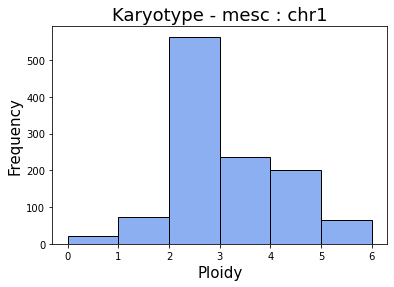

In [14]:
import seaborn as sns

karyo_new = [len(elem) for elem in res]

fig, axs = plt.subplots(figsize = (6, 4))
sns.histplot(karyo_new, color='cornflowerblue', binwidth=1);
axs.set_ylabel('Frequency', fontsize = 15)
axs.set_xlabel('Ploidy', fontsize = 15)
axs.set_title('Karyotype - {0} : {1}'.format(chosen_celltype, chosen_chrom), fontsize = 18)

- What does the spatial distribution of a cell with tetraploid (__4N__) `chosen_chrom = 'chr1'` look like?
    - We can also annotate the mouse __centromeres (▲)__ and mouse __telomeres (✖)__
    <br></br>
    - NB: `finalcellID` corresponds to a unique identifier the dataset authors used to delineate every cell imaged. `cell` correpsonds to the identifier of a given `replicate` in a particular `FOV`.

In [ ]:
show_nucleus(res[158], True, 'Sep-hom')

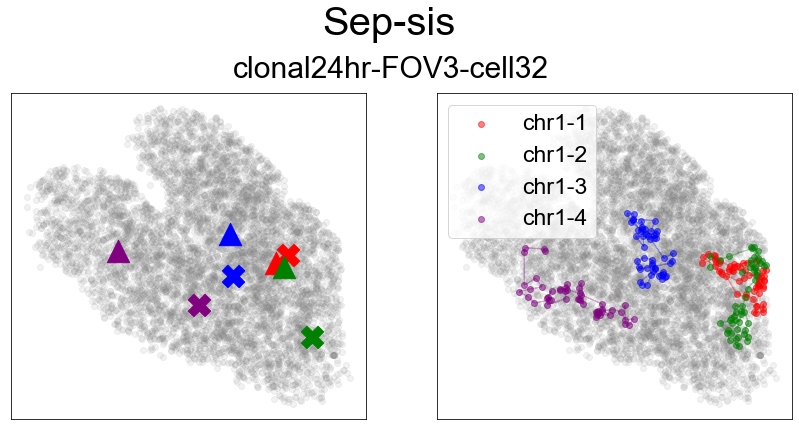

In [18]:
show_nucleus(res[501], True, 'Sep-sis')

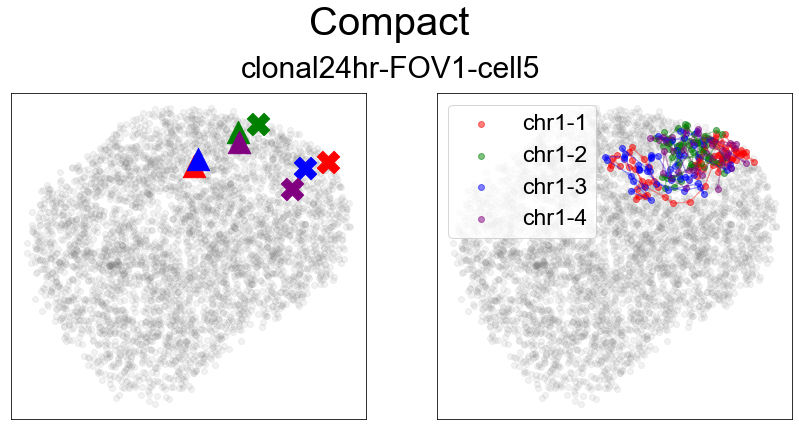

In [19]:
show_nucleus(res[160], True, 'Compact')

- Historically, a particular chromosome is expected to organize into __chromosome territories__ - that is, each homolog resides in a different part of the nucleus.
    - Among `4N` cells it's natural to wonder - are there __4__ chromosome territories?
        - Visual inspection of some of these `4N` cells reveal some broad patterns:
            <br></br>
            - `clonal24hr-FOV1-cell3` shows what appears to be __sister chromatids__ - two homologs and its respsective attendant sister chromatid, each pair residing in different separate territories. Multiple works on sister chromatids show they are __tightly paired__.
            <br></br>
            - `clonal24hr-FOV3-cell32` shows multiple territories (3) in what appears to be a __dividing cell__, evident in the cleavage furrow. Presumably, sister chromatids are in the process of being distributed to daughter cells, resulting in multiple territories.
            <br></br>
            - `clonal24hr-FOV1-cell5` shows 4 chromatin fibers coalescing in __one chromosome territory__. What's happening there?!
<br></br>
- More broadly, we can examine the spatial organization of chromosomes with __density-based clustering__, stratified by ploidy.
    - This way, we can find just how many copy-number-variant cells have __singular__ vs. __multiple__ chromosome territories. 

In [15]:
from sklearn.cluster import DBSCAN

df_ktype = {'replicate': {},
            'FOV': {},
            'cell': {},
            'finalcellID': {},
            'celltype': {},
            'chr': {},
            'ploidy': {},
            'nclusters':{},
            'data':{}}

# DBSCAN params
threshold = 10
eps = 11

# for every cell
for i, cell in enumerate(res):

    if len(cell) > 0:
        
        # merge chromatin fibers
        _df_cell = pd.concat(cell)
        
        # call cluster
        db = DBSCAN(eps=eps, min_samples=threshold).fit(_df_cell[['x_hat', 'y_hat', 'z_hat']])
        n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
       
        # save res
        df_ktype['replicate'][i] = _df_cell.iloc[0]['replicate']
        df_ktype['FOV'][i] = _df_cell.iloc[0]['FOV']
        df_ktype['cell'][i] = _df_cell.iloc[0]['cell']
        df_ktype['finalcellID'][i] = _df_cell.iloc[0]['finalcellID']
        df_ktype['celltype'][i] = _df_cell.iloc[0]['celltype']
        df_ktype['chr'][i] = _df_cell.iloc[0]['chr']
        df_ktype['ploidy'][i] = len(cell)
        df_ktype['nclusters'][i] = n_clusters
        df_ktype['data'][i] = copy.deepcopy(cell)
        
df_ktype = pd.DataFrame(df_ktype)

Text(0.38, 1.1, 'mesc - chr1')

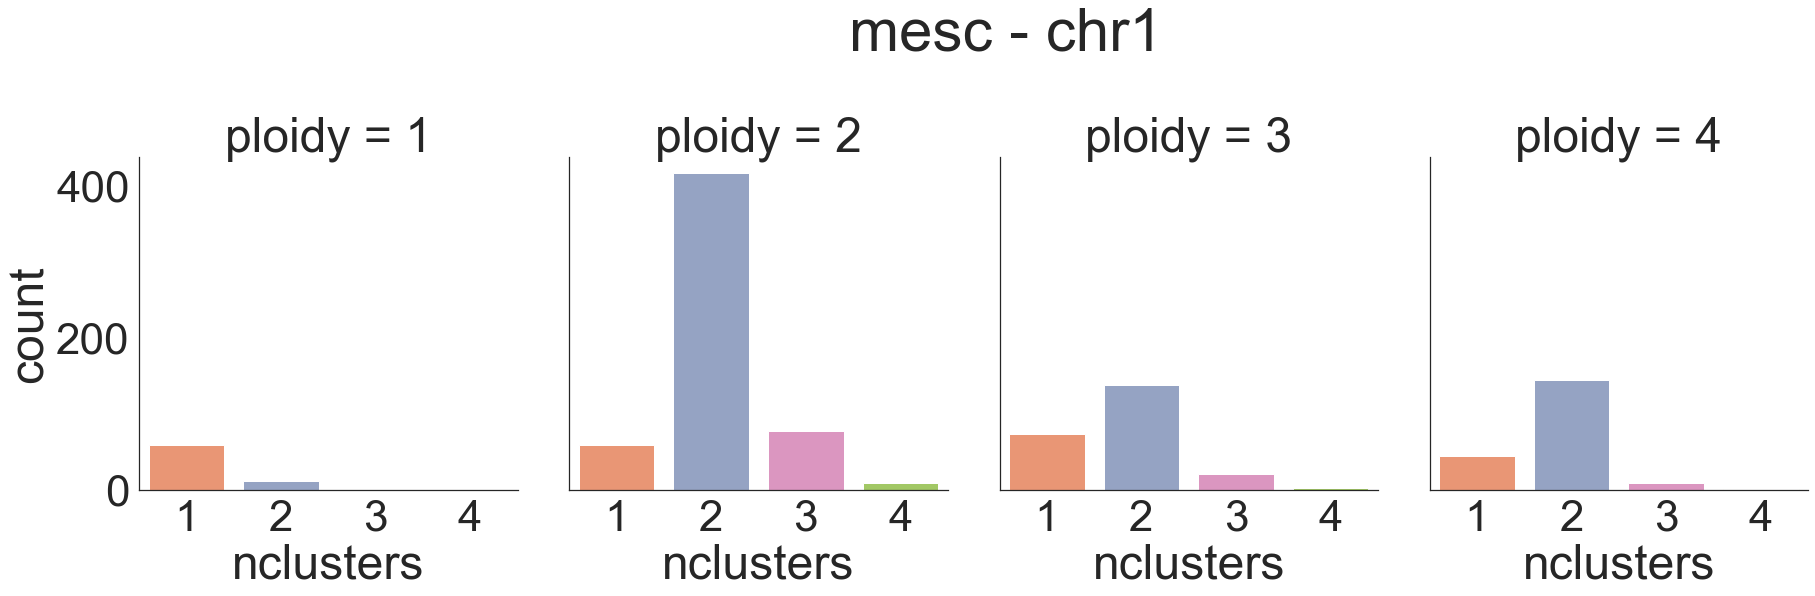

In [16]:
import seaborn as sns

palette ={0: "C0", 1: "C1", 2: "C2", 3: "C3", 4:"C4", 5:"C5"}
sns.set_theme(style="white", font_scale = 4, palette = "Set2")

chosen_celltype = 'mesc'
chosen_chrom = 'chr1'

# plot frequency
g = sns.catplot(data = df_ktype[(df_ktype['chr'] == chosen_chrom) & 
                                (df_ktype['celltype'] == chosen_celltype) & 
                                (df_ktype['ploidy'] <= 4)],
                col = 'ploidy',
                x = 'nclusters', 
                kind = 'count',
                col_wrap = 6,
                height = 8,
                aspect = .8,
                legend_out = False,
                palette = palette)

# annotate
g.fig.suptitle("{0} - {1}".format(chosen_celltype, chosen_chrom), x=0.38, y = 1.1, fontsize = 60)

- It is also easy to inspect the median distance matrices.

In [17]:
import itertools
import warnings
from scipy.spatial.distance import cdist, euclidean

warnings.filterwarnings("ignore", category=RuntimeWarning)

### Helper function ###
def pair_centroids(centroids):
    
    pair_idx = list(itertools.combinations(list(range(4)), 2))
    min_dist = np.inf
    best_pairs = None

    for pair in pair_idx[:3]:

        other_pair = tuple(elem for elem in list(range(4)) if elem not in pair)
        pair1, pair2 = pair
        pair3, pair4 = other_pair

        dist_p = euclidean(centroids[pair1], centroids[pair2])
        dist_op = euclidean(centroids[pair3], centroids[pair4])

        if dist_p+dist_op <= min_dist:
            min_dist = dist_p+dist_op
            best_pairs = [pair1, pair2, pair3, pair4]

    return best_pairs

########################

# grab gene list
chosen_celltype = 'mesc'
chosen_chrom = 'chr1'
gene_dist = df_refgen[df_refgen['Chrom'] == chosen_chrom]['delta'].tolist()

# calculate inter-sister, intra-sister distance matrices
df_sis = {'Inter':[],
          'Intra':[]}

# for every tetraploid cell with separable homologs
for cell in df_ktype[(df_ktype['ploidy'] == 4) & (df_ktype['nclusters'] == 2)]['data']:
    
    # label by sister chromatid
    labeled_chroms = []
    for i, chrom in enumerate(cell):
        _df = copy.deepcopy(chrom)
        _df['sister'] = [i,]*_df.shape[0]
        labeled_chroms.append(_df)
        
    # find centroids
    centroids = [chrom[['x_hat', 'y_hat', 'z_hat']].mean().tolist() for chrom in labeled_chroms]
    
    # pair sisters based on centroid proximity
    best_pair = pair_centroids(centroids)
    
    #### TRANS ####
    # calculate intersis dist
    intersis_dist1 = np.empty((len(gene_dist), len(gene_dist)))
    intersis_dist2 = np.empty((len(gene_dist), len(gene_dist)))
    intersis_dist1[:] = np.nan
    intersis_dist2[:] = np.nan
    
    row_hyb1 = labeled_chroms[best_pair[0]].hyb
    col_hyb1 = labeled_chroms[best_pair[1]].hyb
    row_hyb2 = labeled_chroms[best_pair[2]].hyb
    col_hyb2 = labeled_chroms[best_pair[3]].hyb
    
    mat1 = cdist(labeled_chroms[best_pair[0]][['x_hat', 'y_hat', 'z_hat']], labeled_chroms[best_pair[1]][['x_hat', 'y_hat', 'z_hat']])
    mat2 = cdist(labeled_chroms[best_pair[2]][['x_hat', 'y_hat', 'z_hat']], labeled_chroms[best_pair[3]][['x_hat', 'y_hat', 'z_hat']])
    
    for val, (row, col) in zip(mat1.flatten(), list(itertools.product(row_hyb1, col_hyb1))):
        intersis_dist1[row][col] = val
        
    for val, (row, col) in zip(mat2.flatten(), list(itertools.product(row_hyb2, col_hyb2))):
        intersis_dist2[row][col] = val

    # save trans distances
    df_sis['Inter'].append(intersis_dist1)
    df_sis['Inter'].append(intersis_dist2)
    
    #### CIS ####
    # calculate cis median distance matrix
    for chr_pts in cell:
        intrasis_dist = plot.calc_med_dist_mat([chr_pts], len(gene_dist))
        # save cis
        df_sis['Intra'].append(intrasis_dist)

- Here is how the median _trans_-sister distances stack up against _cis_-sister distances, among spatially separable homologs (`nclusters = 2`):

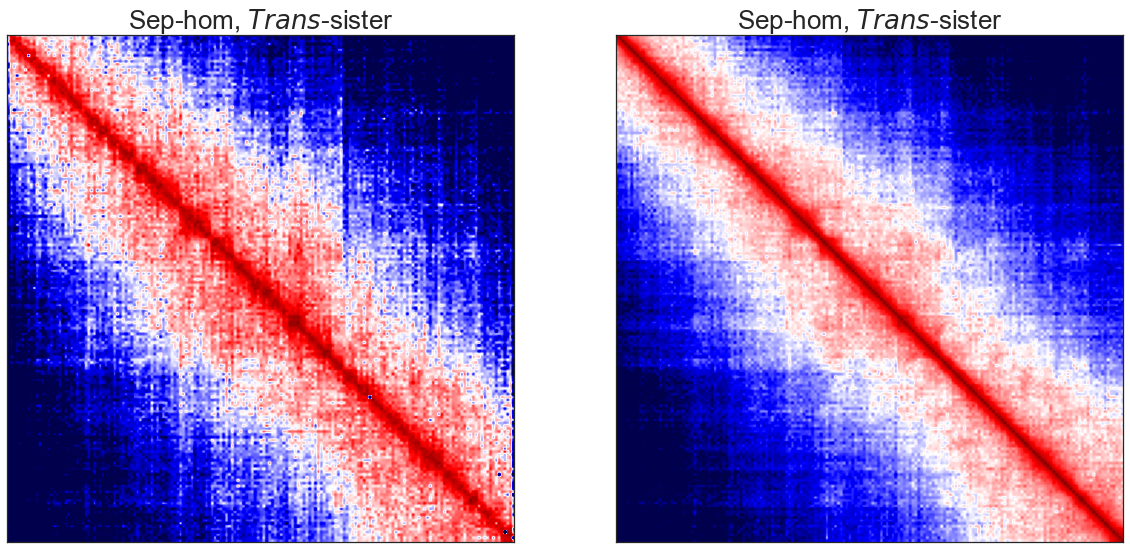

In [18]:
trans_dist = np.nanmedian(df_sis['Inter'], axis = 0)
cis_dist = np.nanmedian(df_sis['Intra'], axis = 0)

fig, axs = plt.subplots(1, 2, figsize = (20, 10))
cmap = matplotlib.cm.get_cmap('seismic_r')
axs[0].imshow(trans_dist*100, cmap = cmap, vmax = 3000)
axs[0].set_title("Sep-hom, "+"$\it{Trans}$-" + "sister".format(chosen_chrom), fontsize = 26)
axs[0].set_xticklabels([]);
axs[0].set_yticklabels([]);

axs[1].imshow(cis_dist*100, cmap = cmap, vmax = 3000)
axs[1].set_title("Sep-hom, "+"$\it{Trans}$-" + "sister".format(chosen_chrom), fontsize = 26)
axs[1].set_xticklabels([]);
axs[1].set_yticklabels([]);

- We can also tabulate to plot the relationship between spatial distance and genomic distance.
    - These cells may take some time to run.

In [19]:
### TRANS dist stats ###
trans_hist = []
for mat in df_sis['Inter']:
    for row, col in np.argwhere(mat):
        gene_delta = np.abs(gene_dist[col] - gene_dist[row])
        obs_dist = mat[row][col]
        trans_hist.append([gene_delta, obs_dist])
        
### CIS dist stats ###
cis_hist = []
for mat in df_sis['Intra']:
    for row, col in np.argwhere(mat):
        gene_delta = np.abs(gene_dist[col] - gene_dist[row])
        obs_dist = mat[row][col]
        cis_hist.append([gene_delta, obs_dist])

### TRANS ###
# tabulate spatial distance given genomic distance
df_trans_dist = pd.DataFrame(trans_hist, columns = ["Actual Genomic distance", "Spatial distance"])
df_trans_dist.dropna(inplace = True)
df_trans_dist['Spatial distance'] = df_trans_dist['Spatial distance'] * 100
df_trans_dist['Category'] = ['Trans',] * df_trans_dist.shape[0]
df_trans_dist.reset_index(inplace = True)

### CIS ###
# tabulate spatial distance given genomic distance
df_cis_dist = pd.DataFrame(cis_hist, columns = ["Actual Genomic distance", "Spatial distance"])
df_cis_dist.dropna(inplace = True)
df_cis_dist['Spatial distance'] = df_cis_dist['Spatial distance'] * 100
df_cis_dist['Category'] = ['Cis',] * df_cis_dist.shape[0]
df_cis_dist.reset_index(inplace = True)

# Concatenate
df_cistrans = pd.concat([df_trans_dist, df_cis_dist])
df_cistrans.reset_index(inplace = True)

# bin data (per 10000 bp)
bin_size = 100000
bins = [bin_size * i for i in range(int(np.round(df_cistrans['Actual Genomic distance'].max() / bin_size)))]
bins[0] = -1
df_cistrans['binned'] = pd.cut(df_cistrans['Actual Genomic distance'], bins, include_lowest = True)
df_cistrans.dropna(inplace = True)
df_cistrans['Genomic distance'] = [elem.right for elem in df_cistrans['binned']]
df_cistrans

,level_0,index,Actual Genomic distance,Spatial distance,Category,binned,Genomic distance
0,0,2,1957518,7656.314317,Trans,"(1900000.0, 2000000.0]",2000000.0
1,1,7,7900000,2600.395677,Trans,"(7800000.0, 7900000.0]",7900000.0
2,2,19,21474972,1565.671663,Trans,"(21400000.0, 21500000.0]",21500000.0
3,3,24,29700000,2721.438714,Trans,"(29600000.0, 29700000.0]",29700000.0
4,4,25,30557295,2180.733715,Trans,"(30500000.0, 30600000.0]",30600000.0
...,...,...,...,...,...,...,...
3243768,2237323,18135215,17677522,8457.370808,Cis,"(17600000.0, 17700000.0]",17700000.0
3243769,2237324,18135217,15640484,8017.335529,Cis,"(15600000.0, 15700000.0]",15700000.0
3243770,2237325,18135219,13566618,7836.741505,Cis,"(13500000.0, 13600000.0]",13600000.0
3243771,2237326,18135220,12477190,6541.561696,Cis,"(12400000.0, 12500000.0]",12500000.0


CPU times: user 1min 19s, sys: 9.18 s, total: 1min 28s
Wall time: 1min 28s


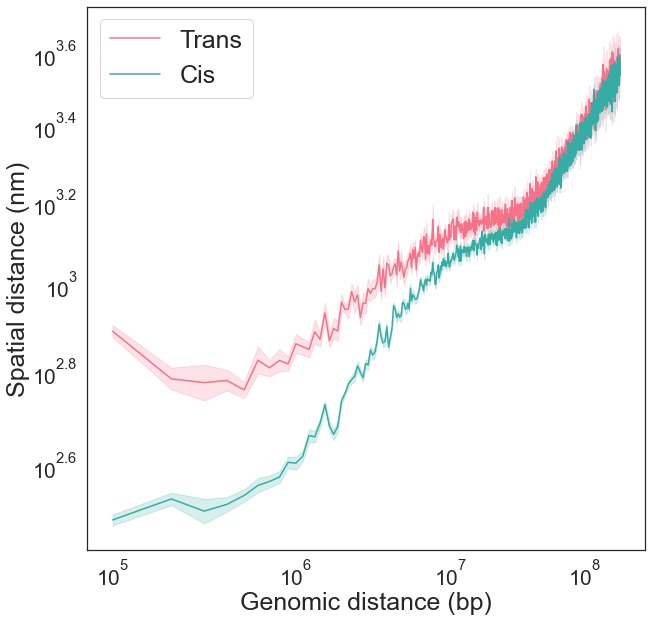

In [20]:
%%time

fig, axs = plt.subplots(figsize = (10, 10))
axs.set(xscale = "log", yscale = "log")
g = sns.lineplot(data = df_cistrans, x='Genomic distance',
           y='Spatial distance', hue = 'Category', 
           palette = "husl")
axs.set_xlabel("Genomic distance (bp)", fontsize = 25, labelpad =2 )
axs.set_ylabel("Spatial distance (nm)", fontsize = 25, labelpad = 2)
xlabels = ['$\\mathdefault{10^{5}}$',
           '$\\mathdefault{10^{6}}$',
           '$\\mathdefault{10^{7}}$',
           '$\\mathdefault{10^{8}}$']
ylabels = ['$\\mathdefault{10^{2.6}}$',
           '$\\mathdefault{10^{2.8}}$',
           '$\\mathdefault{10^{3}}$',
           '$\\mathdefault{10^{3.2}}$',
           '$\\mathdefault{10^{3.4}}$',
           '$\\mathdefault{10^{3.6}}$']
plt.xticks([5, 6, 7, 8], xlabels, fontsize = 21)
plt.yticks([2.6, 2.8, 3, 3.2, 3.4, 3.6], ylabels, fontsize = 21)
plt.legend(fontsize = 25)

- What about those compact chromosomes `nclusters == 1`, `ploidy == 4`? 
    - It's hard to assign sisters with proximity-based clustering since all 4 fibers are coalesced.
        - One way is to assign by a locus of each chromatin fiber - they are likely paired.
            - Something striking here is: the centromeres appear to be tightly paired by sisters, but the telomeres appear to lose this pairing (and instead associate with the other homolog).

Text(-0.13, 1.03, 'replicate1-FOV3-cell34')

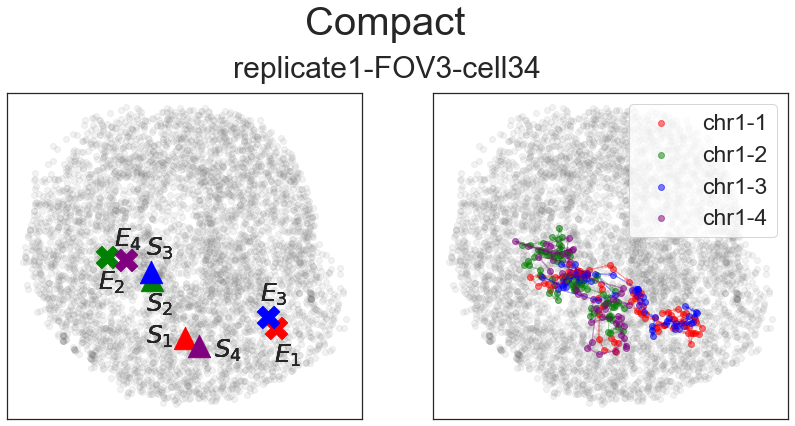

In [21]:
sel_pts = res[561]

# start plot
fig, axs = plt.subplots(1, 2, figsize =(14, 6), sharex = True)
colors = ['red', 'green', 'blue', 'purple']

# grab cell metadata
sel_repl = sel_pts[0].replicate.iloc[0]
sel_fov = sel_pts[0].FOV.iloc[0]
sel_id = sel_pts[0].cell.iloc[0]
sel_cell = sel_pts[0].finalcellID.iloc[0]

## Background
all_cell_pts = df_seqfish[(df_seqfish['finalcellID'] == sel_cell)]

axs[0].scatter(all_cell_pts['x_hat'], all_cell_pts['y_hat'], color='gray', alpha = .1)
axs[1].scatter(all_cell_pts['x_hat'], all_cell_pts['y_hat'], color='gray', alpha = 0.1)

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

## Foreground
# scatter plot all aligned points
for i, elem in enumerate(sel_pts):

    for row_idx in range(elem.shape[0]):

        # skip if centromere or telomere
        if row_idx == 0:
            pass
        # otherwise plot
        else:
            # draw vectors guiding "tracing"
            x_curr, y_curr, z_curr = elem.x_hat.iloc[row_idx], elem.y_hat.iloc[row_idx], elem.z_hat.iloc[row_idx]
            x_prev, y_prev, z_prev = elem.x_hat.iloc[row_idx-1], elem.y_hat.iloc[row_idx-1], elem.z_hat.iloc[row_idx-1]

            axs[1].arrow(x_prev, y_prev, x_curr-x_prev, y_curr-y_prev, color = colors[i], 
                      alpha = 0.3, head_width = 1.7, width = 0.1, length_includes_head = True, overhang = .2)

    # scatter plot all selected coordinates
    axs[1].scatter(elem['x_hat'], elem['y_hat'], color = colors[i], label = '{}-'.format(chosen_chrom)+str(i+1), alpha = 0.5)

    # demarcate centromere & telomere
    x_start, y_start, z_start = elem[['x_hat', 'y_hat', 'z_hat']].iloc[0]
    axs[0].scatter(x_start, y_start, marker='^', color=colors[i], s = 500)
    x_end, y_end, z_end = elem[['x_hat', 'y_hat', 'z_hat']].iloc[-1]
    axs[0].scatter(x_end, y_end, marker='X', color=colors[i], s = 500)
    
    # add telomere and centromere annotation
    axs[0].text(490, 1347, r"$E_{}$".format(1), fontsize=25);
    axs[0].text(426, 1358, r"$S_{}$".format(1), fontsize=25);
    axs[0].text(402, 1390, r"$E_{}$".format(2), fontsize=25);
    axs[0].text(426, 1377, r"$S_{}$".format(2), fontsize=25);
    axs[0].text(483, 1383, r"$E_{}$".format(3), fontsize=25);
    axs[0].text(426, 1410, r"$S_{}$".format(3), fontsize=25);
    axs[0].text(410, 1415, r"$E_{}$".format(4), fontsize=25);
    axs[0].text(460, 1350, r"$S_{}$".format(4), fontsize=25);  

# annotate
plt.suptitle('Compact', fontsize = 40, x=0.5, y = 1.08)
plt.legend(prop={'size': 23}, loc='upper right')
plt.title("{0}-FOV{1}-cell{2}".format(sel_repl, sel_fov, sel_id), x=-.13, y=1.03, fontsize = 30) # 23



In [22]:
import itertools
from scipy.spatial.distance import cdist

def pair_points(loci):
    pair_idx = list(itertools.combinations(list(range(4)), 2))

    min_dist = np.inf
    best_pair = None

    for pair in pair_idx[:3]:

        other_pair = tuple(elem for elem in list(range(4)) if elem not in pair)
        pair1, pair2 = pair
        pair3, pair4 = other_pair

        dist_p = euclidean(loci[pair1], loci[pair2])
        dist_op = euclidean(loci[pair3], loci[pair4])

        if dist_p+dist_op <= min_dist:
            min_dist = dist_p+dist_op
            best_pair = [pair1, pair2, pair3, pair4]

    return best_pair

# choose chrom
chosen_chrom = 'chr1'

# grab gene list
gene_dist = df_refgen[df_refgen['Chrom'] == chosen_chrom]['delta'].tolist()

cishom_transsis_list = []
transhom_transsis_list = []

# for every tetraploid cell with compact chromosomes
for cell in df_ktype[(df_ktype['ploidy'] == 4) & (df_ktype['nclusters'] == 2)]['data']:

    # label by sister chromatid
    labeled_chroms = []
    for i, chrom in enumerate(cell):
        _df = copy.deepcopy(chrom)
        _df['sister'] = [i,]*_df.shape[0]
        labeled_chroms.append(_df)

    # find start and ends
    _starts = [chrom[['x_hat', 'y_hat', 'z_hat']].iloc[0].tolist() for chrom in labeled_chroms]
    _ends = [chrom[['x_hat', 'y_hat', 'z_hat']].iloc[-1].tolist() for chrom in labeled_chroms]

    # pair sisters based on STARTING assignment
    best_pair_s = pair_points(_starts)
    # calculate end pairing to distinguish trans, as telomeres like to pair w/ other homolog
    best_pair_e = pair_points(_ends)

    # calculate cis-homolog, trans-interaction
    cishom_transsis1 = np.empty((len(gene_dist), len(gene_dist)))
    cishom_transsis2 = np.empty((len(gene_dist), len(gene_dist)))
    transhom_transsis1 = np.empty((len(gene_dist), len(gene_dist)))
    transhom_transsis2 = np.empty((len(gene_dist), len(gene_dist)))
    cishom_transsis1[:] = np.nan
    cishom_transsis2[:] = np.nan
    transhom_transsis1[:] = np.nan
    transhom_transsis2[:] = np.nan

    # row, col indeces by pairing
    cishom_transsis_row_hyb1 = labeled_chroms[best_pair_s[0]].hyb
    cishom_transsis_col_hyb1 = labeled_chroms[best_pair_s[1]].hyb
    cishom_transsis_row_hyb2 = labeled_chroms[best_pair_s[2]].hyb
    cishom_transsis_col_hyb2 = labeled_chroms[best_pair_s[3]].hyb

    transhom_transsis_row_hyb1 = labeled_chroms[best_pair_e[0]].hyb
    transhom_transsis_col_hyb1 = labeled_chroms[best_pair_e[1]].hyb
    transhom_transsis_row_hyb2 = labeled_chroms[best_pair_e[2]].hyb
    transhom_transsis_col_hyb2 = labeled_chroms[best_pair_e[3]].hyb

    # calculate distance matrix
    cishom_transsis_mat1 = cdist(labeled_chroms[best_pair_s[0]][['x_hat', 'y_hat', 'z_hat']], labeled_chroms[best_pair_s[1]][['x_hat', 'y_hat', 'z_hat']])
    cishom_transsis_mat2 = cdist(labeled_chroms[best_pair_s[2]][['x_hat', 'y_hat', 'z_hat']], labeled_chroms[best_pair_s[3]][['x_hat', 'y_hat', 'z_hat']])

    transhom_transsis_mat1 = cdist(labeled_chroms[best_pair_e[0]][['x_hat', 'y_hat', 'z_hat']], labeled_chroms[best_pair_e[1]][['x_hat', 'y_hat', 'z_hat']])
    transhom_transsis_mat2 = cdist(labeled_chroms[best_pair_e[2]][['x_hat', 'y_hat', 'z_hat']], labeled_chroms[best_pair_e[3]][['x_hat', 'y_hat', 'z_hat']])

    for val, (row, col) in zip(cishom_transsis_mat1.flatten(), list(itertools.product(cishom_transsis_row_hyb1, cishom_transsis_col_hyb1))):
        cishom_transsis1[row][col] = val

    for val, (row, col) in zip(cishom_transsis_mat2.flatten(), list(itertools.product(cishom_transsis_row_hyb2, cishom_transsis_col_hyb2))):
        cishom_transsis2[row][col] = val

    for val, (row, col) in zip(transhom_transsis_mat1.flatten(), list(itertools.product(transhom_transsis_row_hyb1, transhom_transsis_col_hyb1))):
        transhom_transsis1[row][col] = val

    for val, (row, col) in zip(transhom_transsis_mat2.flatten(), list(itertools.product(transhom_transsis_row_hyb2, transhom_transsis_col_hyb2))):
        transhom_transsis2[row][col] = val

    # append
    cishom_transsis_list.append(cishom_transsis1)
    cishom_transsis_list.append(cishom_transsis2)

    transhom_transsis_list.append(transhom_transsis1)
    transhom_transsis_list.append(transhom_transsis2)


Text(0.5, 1.0, '$\\it{Cis}$-homolog /$\\it{Trans}$-homolog')

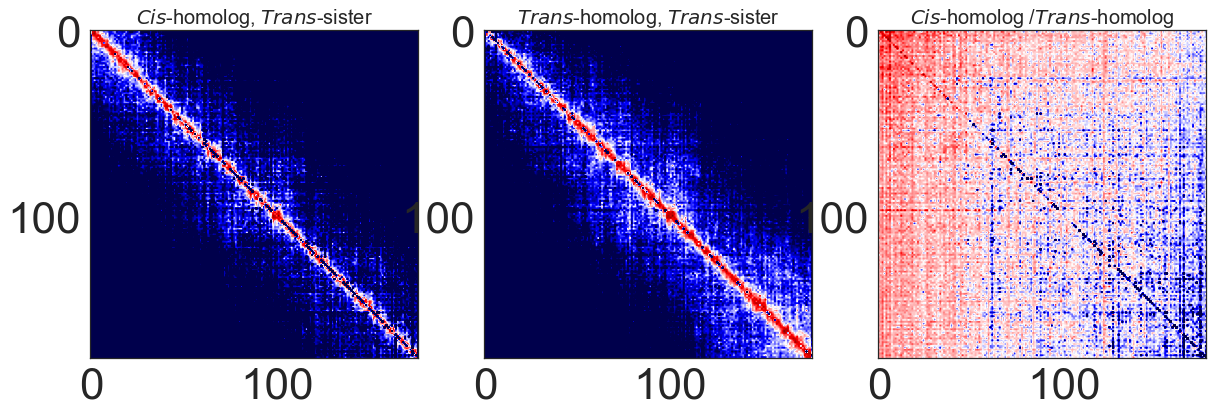

In [23]:
# visualize
final_cishom_transsis = np.nanmedian(cishom_transsis_list, axis = 0)
final_transhom_transsis = np.nanmedian(transhom_transsis_list, axis = 0)

fig, axs = plt.subplots(1, 3, figsize = (20, 10))
axs[0].imshow(final_cishom_transsis*100, cmap = 'seismic_r', vmax = 2000)
axs[1].imshow(final_transhom_transsis*100, cmap = 'seismic_r', vmax = 2000)
axs[2].imshow(final_cishom_transsis/final_transhom_transsis, cmap = 'seismic_r', vmax = 2.2)

# annotate
axs[0].set_title("$\it{Cis}$-homolog, "+ "$\it{Trans}$-sister", fontsize = 20)
axs[1].set_title("$\it{Trans}$-homolog, "+ "$\it{Trans}$-sister", fontsize = 20)
axs[2].set_title("$\it{Cis}$-homolog /"+ "$\it{Trans}$-homolog", fontsize = 20)